In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT
from External.clustering import centers, k_means_pp, ICT_clusters, cfilter, cassign
from External.generation import create_graph, load_image, sample_points_from_image, find_backbone
from External.plotting import plot_points, plot_graph, no_intersections
from External.reweight import reweight_clusters

from copy import deepcopy

# from External.create_k_nearest import patch_together

plt.style.use('animations.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest" # Graph construction mode
image_name = "image"
ICT_algorithm = "cluster_all"
metric = "euclidean" # metric for clustering

# Cluster rassignment
min_cluster_size = 12
small_behavior = "reassign" #reassign or remove

# image loading
n = number_of_nodes = 1000
Random = False


In [6]:
# Compute the position array
img = load_image(image_name)
position = np.array(sample_points_from_image(n,img,Random)).T
position = StandardScaler().fit_transform(position)

Final k: 11
sklearn is done: 0.7246952056884766
My own part is done: 0.0025327205657958984


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

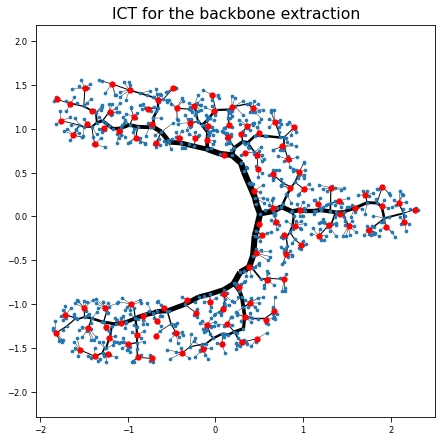

In [7]:
old_G, _ = create_graph(number_of_nodes, mode, position=position, beta=2, delta=0.5)
old_G.indexEdges()

cluster_centers2 = centers(position)
old_ICT = calculate_ICT(old_G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers2, zeros_stay_zeros=True, update_G=1.1)
old_ICT.indexEdges()

# Plot the ICT
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_points(position, f"", ax)
ax.get_legend().remove()
plot_graph(old_ICT, position, f"ICT for the backbone extraction", ax, cluster_centers=cluster_centers2, node_size=0, edge_scale=0.5)

plt.tight_layout()
plt.show()

sklearn is done: 0.665952205657959
My own part is done: 0.002725362777709961


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

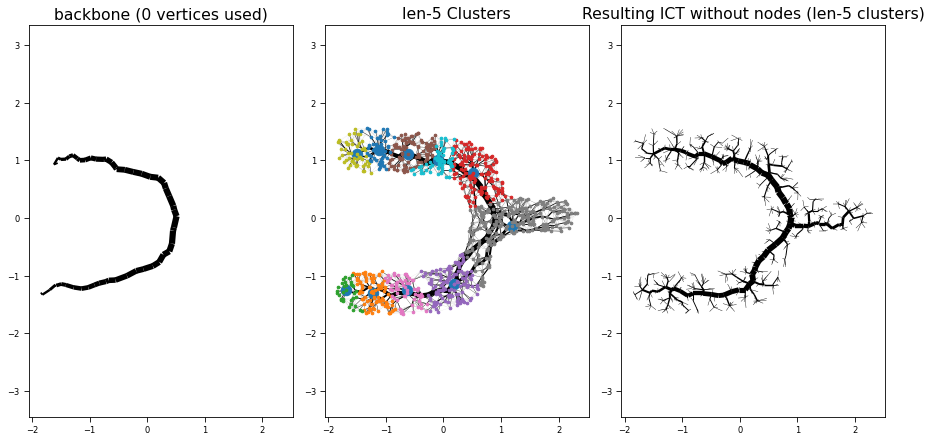

sklearn is done: 0.6508834362030029
My own part is done: 0.002558469772338867


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

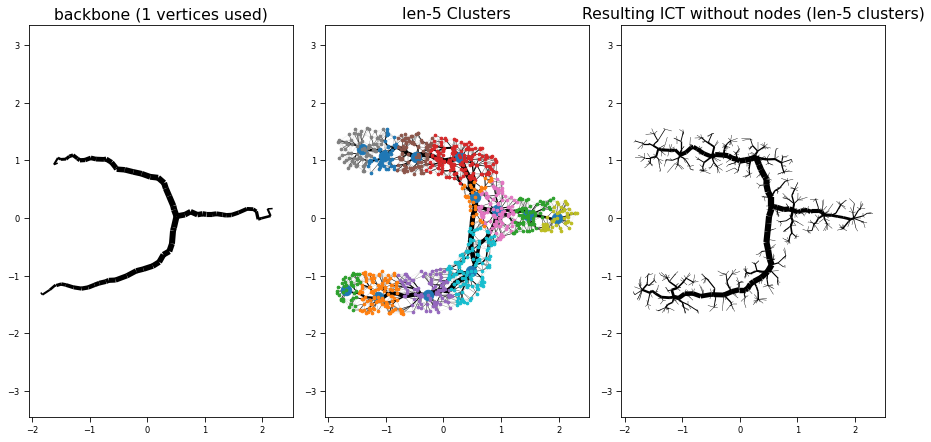

/net/hcihome/storage/flernst/BT/External/clustering.py:309: RuntimeWarning: Small clustersizes occure. Results might not be as expected!
  warnings.warn("Small clustersizes occure. Results might not be as expected!" , RuntimeWarning)


sklearn is done: 0.6557037830352783
My own part is done: 0.0022826194763183594


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

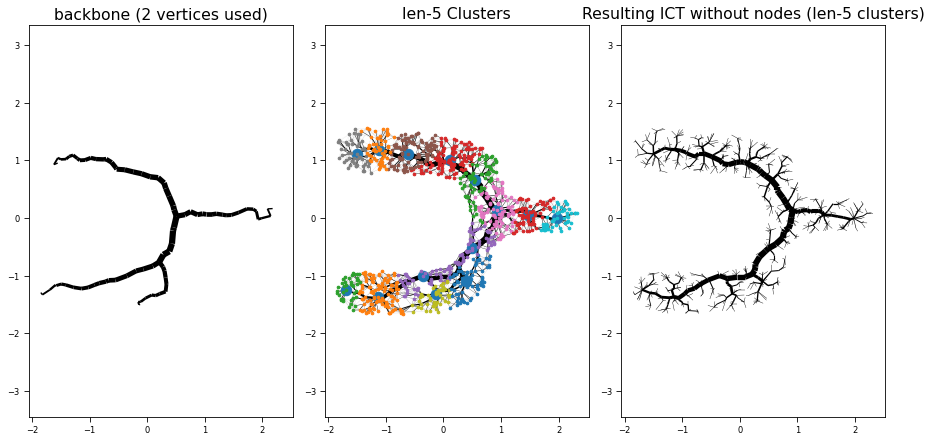

/net/hcihome/storage/flernst/BT/External/clustering.py:309: RuntimeWarning: Small clustersizes occure. Results might not be as expected!
  warnings.warn("Small clustersizes occure. Results might not be as expected!" , RuntimeWarning)


sklearn is done: 0.6399941444396973
My own part is done: 0.0027861595153808594


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

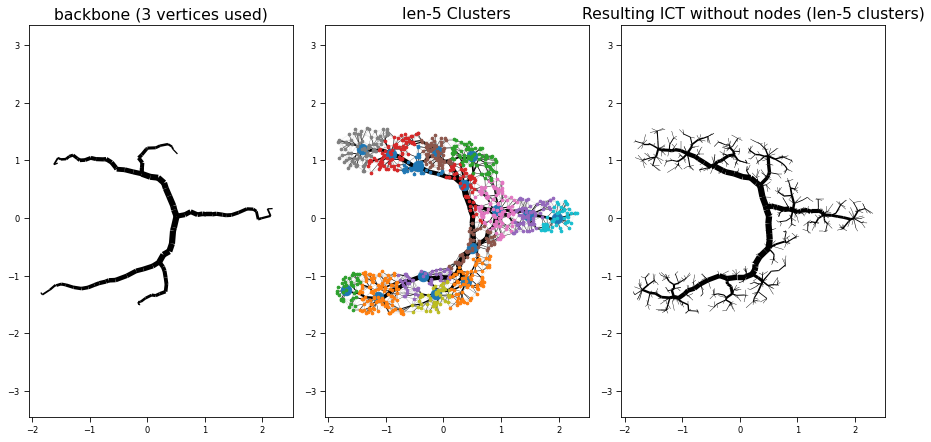

/net/hcihome/storage/flernst/BT/External/clustering.py:309: RuntimeWarning: Small clustersizes occure. Results might not be as expected!
  warnings.warn("Small clustersizes occure. Results might not be as expected!" , RuntimeWarning)


sklearn is done: 0.6563985347747803
My own part is done: 0.002731800079345703


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

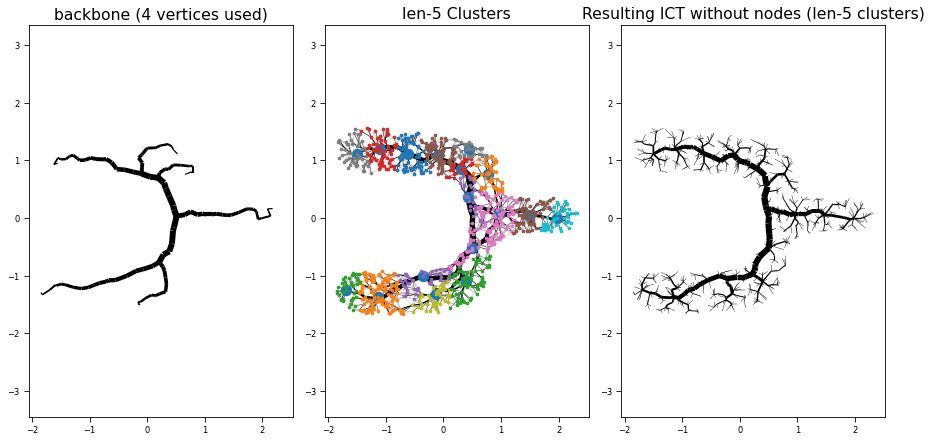

/net/hcihome/storage/flernst/BT/External/clustering.py:309: RuntimeWarning: Small clustersizes occure. Results might not be as expected!
  warnings.warn("Small clustersizes occure. Results might not be as expected!" , RuntimeWarning)


sklearn is done: 0.6604704856872559
My own part is done: 0.0029501914978027344


create edgeId array:   0%|          | 0/6370 [00:00<?, ?it/s]

Calculate the lower bound for the weights:   0%|          | 0/6370 [00:00<?, ?it/s]

Iteration over all nodes:   0%|          | 0/999 [00:00<?, ?it/s]

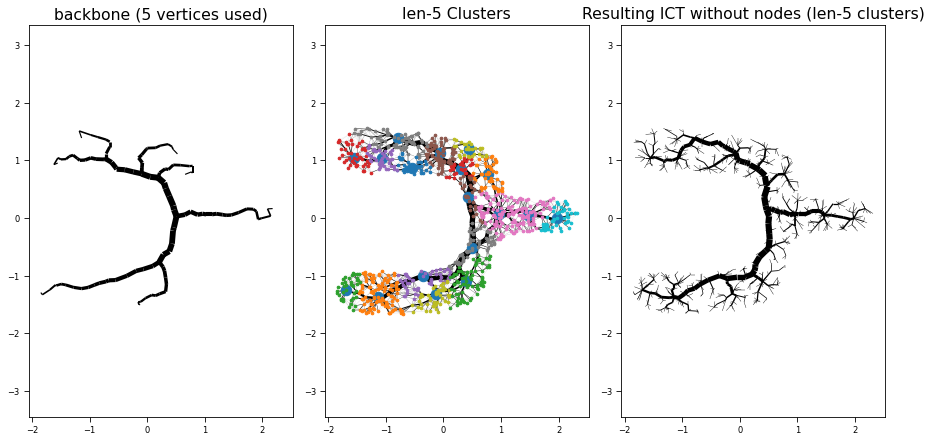

In [8]:
for number_of_vertices in range(0,6):
    
    backbone, backbone_nodes = find_backbone(old_ICT, number_of_vertices=number_of_vertices)
    backbone.indexEdges()
    
    G = deepcopy(old_G)
    cluster_centers, cluster_labels = ICT_clusters(old_ICT, position, number_of_vertices=number_of_vertices, avg_cluster_len=5, log=False)

    if small_behavior == "remove":
        cluster_centers, cluster_labels, (position, ) = cfilter(cluster_centers, cluster_labels, t=min_cluster_size, position_likes=[position])
        number_of_nodes = len(position)
    if small_behavior == "reassign":
        cluster_centers, cluster_labels = cassign(cluster_centers, cluster_labels, position, t=min_cluster_size)

    G = reweight_clusters(position, G, cluster_centers, cluster_labels, min_scale = 0.3, max_scale=1.1)
    
    G.indexEdges()
    
    cluster_centers2 = centers(position)
    
    ICT = calculate_ICT(G, algorithm_type=ICT_algorithm, cluster_centers=cluster_centers2, zeros_stay_zeros=True, update_G=1.1)
        
    ICT.indexEdges()
    
    # Plot the ICT
    
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    plot_graph(backbone, position, f"backbone ({number_of_vertices} vertices used)", axs[0], node_size=0, edge_scale=0.5)
 
    plot_graph(G, position, f"", axs[1], node_size=0, edge_scale=0.5)
    plot_points(position[cluster_centers], f"", axs[1], node_size=20)
    plot_points(position, f"len-{5} Clusters", axs[1], labels=np.array(cluster_labels))
    axs[1].get_legend().remove()
    
    plot_graph(ICT, position, f"Resulting ICT without nodes (len-{5} clusters)", axs[2], node_size=0, edge_scale=0.5)
    name = str(number_of_vertices)
    plt.tight_layout()
    plt.savefig(f"Output/2D-Horseshoe/vertices/" + name.zfill(5) + ".png")
    plt.show()